# Pedestrian classification
Erik Matovič and Jakub Horvat

[Dataset](https://data.nvision2.eecs.yorku.ca/PIE_dataset/)

### 0. Imports

In [1]:
import wandb
from pprint import pprint
import numpy as np
import pandas as pd
import torch 
from torch import flatten
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from utils import split_train_val
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, accuracy_score
from matplotlib import pyplot as plt
from os import listdir
from os.path import join
from pie_data import PIE
from PIL import Image
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

#torch.manual_seed(0)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#device = "cpu"
torch.backends.cudnn.benchmark = True
print(use_cuda, device)

True cuda:0


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xmatovice. Use `wandb login --relogin` to force relogin


True

In [5]:
default_config = {
    'n_features': 5*128,
    'learning_rate': 0.01,
    'epochs': 100,
    'batch_size': 128,
    'momentum': 0.9
}

In [6]:
sweep_config = {
    'name': 'pedestrian_classification',
    'method': 'bayes',
    'metric': {
        'name': 'val_loss', 
        'goal': 'minimize' 
    },
    'early_terminate':{
        'type': 'hyperband',
        'min_iter': 3
    },
    'parameters': {
        'batch_size': {
            'values': [8, 16, 32, 64, 128]
        },
        'epochs': {
            'values': [10, 50, 100]
        },
        'learning_rate': {
            'min': 0.001,
            'max': 0.1
        },
        'n_features': {
            'values': [32, 64, 128, 256, 512]
        },
        'momentum': {
            'min': 0.0,
            'max': 0.99
        }, 
    }
}

pprint(sweep_config)

sweep_id = wandb.sweep(sweep_config)

{'early_terminate': {'min_iter': 3, 'type': 'hyperband'},
 'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'name': 'pedestrian_classification',
 'parameters': {'batch_size': {'values': [8, 16, 32, 64, 128]},
                'epochs': {'values': [10, 50, 100]},
                'learning_rate': {'max': 0.1, 'min': 0.001},
                'momentum': {'max': 0.99, 'min': 0.0},
                'n_features': {'values': [32, 64, 128, 256, 512]}}}
Create sweep with ID: 6erje4vd
Sweep URL: https://wandb.ai/xmatovice/uncategorized/sweeps/6erje4vd


### 1. EDA
 - in [Exploratory Data Analysis](./EDA.ipynb)
 
### 2. Data preprocessing

In [7]:
class PIE_dataset(Dataset):
    """
    Dataset class for dataloader.
    """
    def __init__(self, setname: str, pie: PIE) -> None:
        """
        Dataset init.
        :param setname: specifying trainig, validation or test set
        """
        assert setname in ['train', 'val', 'test'], 'wrong setname, accepting only \'train\', \'val\', \'test\''
        
        super().__init__()
        self.setname = setname
        self.img_path = pie._images_path + '/' + self.setname + '/'
        self.annotations_path = '../' + self.setname + '_annotations.csv'
        self.all_filenames = listdir(self.img_path)
        self.all_annotations = pd.read_csv(self.annotations_path)     
        self.all_annotations_meaning = self.all_annotations.columns.values.tolist()

        # Setting labels
        self.label_action = self.all_annotations['action']
        self.label_gender = self.all_annotations['gender']
        self.label_look = self.all_annotations['look']
        self.label_cross = self.all_annotations['cross']   
        
    
    def __len__(self) -> int:
        """
        Return the total number of images.
        returns: The total number of images.
        """
        return len(self.all_filenames)
    

    def __getitem__(self, index) -> dict:
        """
        Get item with annotations.
        :param index: the number of image
        returns: Dictionary.
        """
        file_name = self.all_filenames[index]
        img_path = self.img_path + file_name
        # print(img_path)
        
        # Read the input image
        img = Image.open(img_path)#.convert('RGB')
        # convert image to torch tensor
        img_tensor = transforms.ToTensor()(img)
        # Transform to normalize the image with mean and std of the ImageNet dataset
        transform = transforms.Normalize(mean=(0.2,), std=(0.2,))
        normalized_img_tensor = transform(img_tensor)
        # convert the normalized tensor to PIL image
        # normalized_img = transforms.ToPILImage()(normalized_img_tensor)
        # normalized_img.show()

        # train
        set_idx_start = 16
        ped_index_start = 38
        
        # val
        if self.setname == 'val':
            set_idx_start = 14
            ped_index_start = 36

        # test
        if self.setname == 'test':
            set_idx_start = 15
            ped_index_start = 37

        # pedestrian index is varying from index 38 to 41
        ped_index = img_path.index('_', ped_index_start)

        set_name = img_path[set_idx_start:set_idx_start+5]
        video_name = img_path[set_idx_start+6:set_idx_start+16]
        ped_name = img_path[set_idx_start+17:ped_index]
        frame_name = img_path[ped_index + 1:]
        #print(set_name, video_name, ped_name, frame_name)
        
        label = self.all_annotations.loc[
            (self.all_annotations.set == set_name) &
            (self.all_annotations.video == video_name) &
            (self.all_annotations.frame == frame_name) &
            (self.all_annotations.ped == ped_name)
        ]
        #print(label)

        label_action = torch.tensor(self.label_action[label.index[0]], dtype=torch.float)
        label_gender = torch.tensor(self.label_gender[label.index[0]], dtype=torch.float)
        label_look = torch.tensor(self.label_look[label.index[0]], dtype=torch.float)
        label_cross = torch.tensor(self.label_cross[label.index[0]], dtype=torch.long)
        
        return {'data': normalized_img_tensor,
                'label_action': label_action,
                'label_gender': label_gender,
                'label_look': label_look,
                'label_cross': label_cross,
                'img_idx': index}

## 3. Model

In [16]:
class CNN(nn.Module):
    """
    Model class
    """
    def __init__(self, n_channels, n_features) -> None:
        """
        init
        :param n_channels: number of input challens
        """
        super(CNN, self).__init__()
        self.n_channels = n_channels
        self.n_features = n_features

        # initialize first set of CONV => RELU => CONV => RELU => POOL layers
        self.conv11 = nn.Conv2d(in_channels=n_channels, out_channels=64, 
                             kernel_size=(3, 3), padding=0, dilation=2)
        self.conv12 = nn.Conv2d(in_channels=64, out_channels=64,
			    kernel_size=(3, 3), padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize second set of CONV => RELU => CONV => RELU => POOL layers
        #self.conv21 = nn.Conv2d(in_channels=cnn_channels, out_channels=cnn_channels, #28
		#	kernel_size=(5, 5), padding=1)
        #self.conv22 = nn.Conv2d(in_channels=cnn_channels, out_channels=cnn_channels, #26
		#	kernel_size=(3, 3), padding=1)
        #self.dropout_cnn = nn.Dropout(p=0.5)

		# initialize second set of CONV => RELU => CONV => RELU => POOL layers
        #self.conv31 = nn.Conv2d(in_channels=128, out_channels=64, #28
		#	kernel_size=(3, 3), padding=1)
        #self.conv32 = nn.Conv2d(in_channels=64, out_channels=64, #26
		#	kernel_size=(3, 3), padding=1)

		# initialize second set of CONV => RELU => CONV => RELU => POOL layers
        #self.conv41 = nn.Conv2d(in_channels=64, out_channels=64, #28
		#	kernel_size=(3, 3), padding=1)
        #self.conv42 = nn.Conv2d(in_channels=64, out_channels=64, #26
		#	kernel_size=(3, 3), padding=1)

        # MLP
        # initialize first set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=53824, out_features=n_features) # 9216?
        self.relu = nn.LeakyReLU() # nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

		# initialize second set of FC => RELU layers
        self.fc2 = nn.Linear(in_features=n_features, out_features=n_features)
        self.fc3 = nn.Linear(in_features=n_features, out_features=n_features)
        self.fc4 = nn.Linear(in_features=n_features, out_features=2*128)
        self.fc5 = nn.Linear(in_features=2*128, out_features=2*128)

        self.fc_action = nn.Linear(2*128, 1)      # output action class
        self.fc_gender = nn.Linear(2*128, 1)      # output gesture class
        self.fc_look = nn.Linear(2*128, 1)        # output look class
        self.fc_cross = nn.Linear(2*128, 3)       # output cross class

        self.logSoftmax = nn.LogSoftmax(dim=1) #dim=1 je ze to robi po riadkoch
        self.BCELoss = nn.BCEWithLogitsLoss() 


    def forward(self, x) -> dict:        
        """
        forward pass
        :param x: data x
        """
        # pass the input through our first set of CONV => RELU => POOL layers
        output = self.conv11(x)
        output = self.relu(output)
        output = self.conv12(output)
        output = self.relu(output)
        output = self.maxpool(output)

		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
        #print(output.shape)
        output = flatten(output, 1)
        #print(output)
        #print("after flatten ", output.shape)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.dropout(output)
		
        output = self.fc2(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.fc3(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.fc4(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.fc5(output)
        output = self.relu(output)
        output = self.dropout(output)

        # pass output to 4 different layers to get 4 classes
        label_action = self.fc_action(output)
        label_gender = self.fc_gender(output) # torch.sigmoid(self.fc2(X))  
        label_look = self.fc_look(output)
        label_cross = self.fc_cross(output)

        # pass the output to our logSoftmax classifier to get our output
        #label_action = self.sigmoid(label_action)
        #label_gender = self.sigmoid(label_gender)
        #label_look = self.sigmoid(label_look)
        #label_cross = self.logSoftmax(label_cross)
        
        # return 4 classes
        return {'label_action': label_action,
                'label_gender': label_gender,
                'label_look': label_look,
                'label_cross': label_cross}

## 4. training & validation

In [17]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    return correct

In [18]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [19]:
def val_cnn(val_dl, loss_fn, model, device):
    """
    Validation
    """
    # init epoch validation counters
    epoch_train_accuracy_action, epoch_train_total_action, \
        epoch_train_true_action, epoch_train_loss = 0, 0, 0, 0
    
    epoch_train_accuracy_gender, epoch_train_total_gender, \
        epoch_train_true_gender = 0, 0, 0
    
    epoch_train_accuracy_look, epoch_train_total_look, \
        epoch_train_true_look = 0, 0, 0
    
    epoch_train_accuracy_cross, epoch_train_total_cross, \
        epoch_train_true_cross = 0, 0, 0
    
    # disable gradient calculation
    with torch.no_grad():
        # enumerate mini batches
        for _, sample in enumerate(val_dl):
            # get X and y with index from sample
            X_batch, y_batch_action, y_batch_gender, \
                y_batch_look, y_batch_cross, idx = sample['data'], sample['label_action'], \
                    sample['label_gender'], sample['label_look'], sample['label_cross'], \
                        sample['img_idx']
            
            # y_batch_cross = y_batch_cross.type(torch.LongTensor)
            
            X_batch, y_batch_action, y_batch_gender, y_batch_look, y_batch_cross = \
                X_batch.to(device), y_batch_action.to(device), y_batch_gender.to(device), \
                    y_batch_look.to(device), y_batch_cross.to(device)
                     
            # compute the model output
            # Make prediction logits with model
            y_hat = model(X_batch)
            y_action = y_hat['label_action']
            y_gender = y_hat['label_gender']
            y_look = y_hat['label_look']
            y_cross = y_hat['label_cross']

            y_cross_ = model.logSoftmax(y_cross) 
            y_cross_1 = torch.argmax(y_cross_, dim=1).type(torch.LongTensor).to(device)
            
            _, y_action_ = torch.max(y_action, dim=1) 
            _, y_gender_ = torch.max(y_gender, dim=1)
            _, y_look_ = torch.max(y_look, dim=1)

            #y_cross_1 = torch.argmax(y_cross)
            loss_action = model.BCELoss(y_action, y_batch_action.unsqueeze(1))
            loss_gender = model.BCELoss(y_gender, y_batch_gender.unsqueeze(1))
            loss_look = model.BCELoss(y_look, y_batch_look.unsqueeze(1))
            loss_cross = loss_fn(y_cross_, y_batch_cross)
            
            loss = loss_action + loss_gender + loss_look + loss_cross
            
            # update train counters
            epoch_train_loss += loss.item()

            epoch_train_true_action += accuracy_fn(y_action_, y_batch_action)
            epoch_train_total_action += len(y_batch_action)

            epoch_train_true_gender += accuracy_fn(y_gender_, y_batch_gender)
            epoch_train_total_gender += len(y_batch_gender)

            epoch_train_true_look += accuracy_fn(y_look_, y_batch_look)
            epoch_train_total_look += len(y_batch_look)

            epoch_train_true_cross += accuracy_fn(y_cross_1, y_batch_cross)
            epoch_train_total_cross += len(y_batch_cross)

        # update train accuracy & loss statistics
        epoch_train_loss /= (len(val_dl.dataset)/val_dl.batch_size)
        
        epoch_train_accuracy_action = (epoch_train_true_action/epoch_train_total_action) * 100
        epoch_train_accuracy_gesture = (epoch_train_true_gender/epoch_train_total_gender) * 100
        epoch_train_accuracy_look = (epoch_train_true_look/epoch_train_total_look) * 100
        epoch_train_accuracy_cross = (epoch_train_true_cross/epoch_train_total_cross) * 100

    return epoch_train_loss, epoch_train_accuracy_action, epoch_train_accuracy_gesture, \
        epoch_train_accuracy_look, epoch_train_accuracy_cross
    

In [20]:
def train_cnn(train_dl:DataLoader, val_dl:DataLoader, n_epochs:int, optimizer: optim, model: nn.Module, loss_fn: nn.NLLLoss, device):
    """
    Training
    """
    # init train lists for statistics
    loss_train, acc_action_train, acc_gender_train, \
        acc_look_train, acc_cross_train = list(), list(), list(), list(), list()

    # init validation lists for statistics
    loss_val, acc_action_val, acc_gender_val, \
        acc_look_val, acc_cross_val = list(), list(), list(), list(), list()
    
    early_stopper = EarlyStopper(patience=3, min_delta=1)    
    # enumerate epochs
    for epoch in range(n_epochs):
        # init epoch train counters
        epoch_train_accuracy_action, epoch_train_total_action, \
            epoch_train_true_action, epoch_train_loss = 0, 0, 0, 0
        
        epoch_train_accuracy_gender, epoch_train_total_gender, \
            epoch_train_true_gender = 0, 0, 0
        
        epoch_train_accuracy_look, epoch_train_total_look, \
            epoch_train_true_look = 0, 0, 0
        
        epoch_train_accuracy_cross, epoch_train_total_cross, \
            epoch_train_true_cross = 0, 0, 0

        # enumerate mini batches
        for _, sample in enumerate(train_dl):
            # get X and y with index from sample
            X_batch, y_batch_action, y_batch_gender, \
                y_batch_look, y_batch_cross, idx = sample['data'], sample['label_action'], \
                    sample['label_gender'], sample['label_look'], sample['label_cross'], \
                        sample['img_idx']
            
            X_batch, y_batch_action, y_batch_gender, y_batch_look, y_batch_cross = \
                X_batch.to(device), y_batch_action.to(device), y_batch_gender.to(device), \
                    y_batch_look.to(device), y_batch_cross.to(device)
            
            # clear the gradients
            optimizer.zero_grad()
            
            # compute the model output
            # Make prediction logits with model
            y_hat = model(X_batch)
            y_action = y_hat['label_action']
            y_gender = y_hat['label_gender']
            y_look = y_hat['label_look']
            y_cross = y_hat['label_cross']

            y_cross_ = model.logSoftmax(y_cross) 
            y_cross_1 = torch.argmax(y_cross_, dim=1).type(torch.LongTensor).to(device)
            
            _, y_action_ = torch.max(y_action, dim=1) #.round().int()
            _, y_gender_ = torch.max(y_gender, dim=1) #.round().int()
            _, y_look_ = torch.max(y_look, dim=1) #.round().int()
            
            loss_action = model.BCELoss(y_action, y_batch_action.unsqueeze(1))
            loss_gender = model.BCELoss(y_gender, y_batch_gender.unsqueeze(1))
            loss_look = model.BCELoss(y_look, y_batch_look.unsqueeze(1))
            loss_cross = loss_fn(y_cross_, y_batch_cross)

            loss = loss_action + loss_gender + loss_look + loss_cross
            
            loss.backward()
            
            optimizer.step()

            # update train counters
            epoch_train_loss += loss.item()

            epoch_train_true_action += accuracy_fn(y_action_, y_batch_action)
            epoch_train_total_action += len(y_batch_action)

            epoch_train_true_gender += accuracy_fn(y_gender_, y_batch_gender)
            epoch_train_total_gender += len(y_batch_gender)

            epoch_train_true_look += accuracy_fn(y_look_, y_batch_look)
            epoch_train_total_look += len(y_batch_look)

            epoch_train_true_cross += accuracy_fn(y_cross_1, y_batch_cross)
            epoch_train_total_cross += len(y_batch_cross)

        # update train accuracy & loss statistics
        epoch_train_loss /= (len(train_dl.dataset)/train_dl.batch_size)
        
        epoch_train_accuracy_action = (epoch_train_true_action/epoch_train_total_action) * 100
        epoch_train_accuracy_gender = (epoch_train_true_gender/epoch_train_total_gender) * 100
        epoch_train_accuracy_look = (epoch_train_true_look/epoch_train_total_look) * 100
        epoch_train_accuracy_cross = (epoch_train_true_cross/epoch_train_total_cross) * 100
        
        # validation
        epoch_val_loss, epoch_val_acc_action, epoch_val_acc_gender, \
            epoch_val_acc_look, epoch_val_acc_cross = val_cnn(val_dl=val_dl, 
                                                              model=model, 
                                                              loss_fn=loss_fn, 
                                                              device=device)
        
        # update global train stats
        loss_train.append(epoch_train_loss)
        acc_action_train.append(epoch_train_accuracy_action)
        acc_gender_train.append(epoch_train_accuracy_gender)
        acc_look_train.append(epoch_train_accuracy_look)
        acc_cross_train.append(epoch_train_accuracy_cross)

        # update global validation stats
        loss_val.append(epoch_val_loss)
        acc_action_val.append(epoch_val_acc_action) 
        acc_gender_val.append(epoch_val_acc_gender)
        acc_look_val.append(epoch_val_acc_look)
        acc_cross_val.append(epoch_val_acc_cross)

        # print
        if epoch % 1 == 0: #== (n_epochs - 1):
            print(
                f'Epoch {epoch}/{n_epochs}: \
                train loss {loss_train[-1]}, \
                val loss {loss_val[-1]}, \
                action train acc {acc_action_train[-1]}, \
                gender train acc {acc_gender_train[-1]}, \
                look train acc {acc_look_train[-1]}, \
                cross train acc {acc_cross_train[-1]}, \
                action val acc {acc_action_val[-1]}, \
                gender val acc {acc_gender_val[-1]}, \
                look val acc {acc_look_val[-1]}, \
                cross val acc {acc_cross_val[-1]}'
            )

        # log metrics to WandB
        wandb.log({"train loss": epoch_train_loss, 
                    "val_loss": epoch_val_loss,
                    "action train acc": epoch_train_accuracy_action,
                    "gender train acc": epoch_train_accuracy_gender,
                    "look train acc": epoch_train_accuracy_look,
                    "cross train acc": epoch_train_accuracy_cross,
                    "action val acc": epoch_val_acc_action,
                    "gender val acc": epoch_val_acc_gender,
                    "look val acc": epoch_val_acc_look,
                    "cross val acc": epoch_val_acc_cross}
                    ) 
        
        # early stopping
        if early_stopper.early_stop(epoch_val_loss):    
            print(f'Early stopped at {epoch}')         
            break

    return loss_train, acc_action_train, acc_gender_train, acc_look_train, \
        acc_cross_train, loss_val, acc_action_val, acc_gender_val, \
            acc_look_val, acc_cross_val

In [21]:
def evaluation(model, test_dl):
    """
    evaluation
    """    
    y_test_all_action, y_test_all_gender, y_test_all_cross, y_test_all_look = list(), list(), list(), list()
    y_all_action, y_all_gender, y_all_cross, y_all_look = list(), list(), list(), list()
    # total_action, total_gesture, total_cross, total_look = 0, 0, 0, 0
    correct_action, correct_gender, correct_cross, correct_look = 0, 0, 0, 0
    # disable gradient calculation
    with torch.no_grad():
        # enumerate mini batches
        for _, sample in enumerate(test_dl):
            # get X and y with index from sample
            X_batch, y_batch_action, y_batch_gender, \
                y_batch_look, y_batch_cross, idx = sample['data'], sample['label_action'], \
                    sample['label_gender'], sample['label_look'], sample['label_cross'], \
                        sample['img_idx']
            
            X_batch, y_batch_action, y_batch_gender, y_batch_look, y_batch_cross = \
                X_batch.to(device), y_batch_action.to(device), y_batch_gender.to(device), \
                    y_batch_look.to(device), y_batch_cross.to(device)
                     
            # compute the model output
            # Make prediction logits with model
            y_hat = model(X_batch)
            y_action = y_hat['label_action']
            y_gender = y_hat['label_gender']
            y_look = y_hat['label_look']
            y_cross = y_hat['label_cross']
            
            y_cross_ = model.logSoftmax(y_cross) 

            true_cross_max = torch.argmax(y_cross_, dim=1)

            #y_action_ = model.logSoftmax(y_action) 
            _, y_action_ = torch.max(y_action, dim=1) #.round().int()
            _, y_gender_ = torch.max(y_gender, dim=1) #.round().int()
            _, y_look_ = torch.max(y_look, dim=1) #.round().int()
            
            # accuracies
            true_action = accuracy_fn(y_action_, y_batch_action)
            true_gender = accuracy_fn(y_gender_, y_batch_gender)
            true_look = accuracy_fn(y_look_, y_batch_look)
            true_cross = accuracy_fn(true_cross_max, y_batch_cross)
        
            # update predictions stats
            y_all_action.extend(y_action_.cpu().numpy())
            y_all_gender.extend(y_gender_.cpu().numpy())
            y_all_look.extend(y_look_.cpu().numpy())
            y_all_cross.extend(true_cross_max.cpu().numpy())

            # update batch y stats
            y_test_all_action.extend(y_batch_action.cpu().numpy())
            y_test_all_gender.extend(y_batch_gender.cpu().numpy())
            y_test_all_look.extend(y_batch_look.cpu().numpy())
            y_test_all_cross.extend(y_batch_cross.cpu().numpy())

            correct_action += true_action
            correct_gender += true_gender
            correct_look += true_look
            correct_cross += true_cross

    #print(y_test_all_action)
    #print(y_all_action)
    report_action = classification_report(y_test_all_action, y_all_action, target_names=['0', '1'])
    report_gender = classification_report(y_test_all_gender, y_all_gender, target_names=['0', '1'])#, '1', '2'])
    report_look = classification_report(y_test_all_look, y_all_look, target_names=['0', '1'])
    report_cross = classification_report(y_test_all_cross, y_all_cross, target_names=['0', '1', '2'])

    matrix_action = confusion_matrix(y_test_all_action, y_all_action)
    matrix_gender = confusion_matrix(y_test_all_gender, y_all_gender)
    matrix_look = confusion_matrix(y_test_all_look, y_all_look)
    matrix_cross = confusion_matrix(y_test_all_cross, y_all_cross)
    
    matrix_action_display = ConfusionMatrixDisplay(matrix_action, display_labels=['0', '1'])
    matrix_gender_display = ConfusionMatrixDisplay(matrix_gender, display_labels=['0', '1'])
    matrix_look_display = ConfusionMatrixDisplay(matrix_look, display_labels=['0', '1'])
    matrix_cross_display = ConfusionMatrixDisplay(matrix_cross, display_labels=['0', '1', '2'])

    return report_action, report_gender, report_look, report_cross, \
        matrix_action_display, matrix_gender_display, \
            matrix_look_display, matrix_cross_display
    

In [22]:
def wandb_sweep(): #-> Tuple[List, List, List, List]:
    """ 
    Train the model
    n_epochs, mlp, optimizer, loss_fn, 
              train_dl, val_dl, device, default_config
    """    
    torch.cuda.empty_cache()
    
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="pedestrian_classification",
        # track hyperparameters and run metadata
        config=default_config
    )

    config = wandb.config
    # define training hyperparameters
    INIT_LR = config.learning_rate #0.001 #1e-3
    #W_DECAY = 1e-6
    EPOCHS = config.epochs 
    MOMENTUM = config.momentum
    #CUDA_LAUNCH_BLOCKING=1

    # initialize the LeNet model
    print("[INFO] initializing the CNN model...")
    n_channels = 1 # 1 for grayscale
    n_features = config.n_features 

    pie_path = '../' 
    pie = PIE(data_path=pie_path)
    
    train_dataset = PIE_dataset('train', pie)
    val_dataset = PIE_dataset('val', pie)
    test_dataset = PIE_dataset('test', pie)

    BATCH_SIZE = config.batch_size

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) #, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) #, num_workers=4)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) #, num_workers=4)

    model = CNN(
        n_channels=n_channels, 
        n_features=n_features
    ) 

    model.to(device)

    # initialize our optimizer and loss function
    opt = optim.SGD(model.parameters(), lr=INIT_LR, momentum=MOMENTUM) #optim.Adam(model.parameters(), lr=INIT_LR, capturable=False)
    lossFn = nn.CrossEntropyLoss() #nn.NLLLoss()
    #learning_rate = config.learning_rate    #  # 0.001 
    #input_size = 20                         # number of features
    # hidden_size = config.hidden_size        #  #64         # number of features in hidden state
    #num_classes = 4                 # number of output classes 

    #n_epochs = config.epochs        
    #batch_size = config.batch_size  
    loss_train, acc_action_train, acc_gender_train, acc_look_train, \
        acc_cross_train, loss_val, acc_action_val, acc_gender_val, \
            acc_look_val, acc_cross_val = \
                train_cnn(
        n_epochs=EPOCHS,
        model=model,
        optimizer=opt,
        loss_fn=lossFn,
        train_dl=train_dataloader,
        val_dl=val_dataloader,
        device=device
    )
    
    report_action, report_gender, report_look, report_cross, \
        matrix_action_display, matrix_gender_display, \
            matrix_look_display, matrix_cross_display = evaluation(model, test_dataloader)
    pprint(report_action)
    pprint(report_gender)
    pprint(report_look)
    pprint(report_cross)
    matrix_action_display.plot(cmap='Blues')
    matrix_gender_display.plot(cmap='Blues')
    matrix_look_display.plot(cmap='Blues')
    matrix_cross_display.plot(cmap='Blues')

wandb: Agent Starting Run: 5ar6t9yf with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0024432864428872393
wandb: 	momentum: 0.819311658732357
wandb: 	n_features: 512
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[INFO] initializing the CNN model...
Epoch 0/10:                 train loss 3.128489565622011,                 val loss 3.0748075512348194,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 56.4977420973407,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,                 cross val acc 94.7867298578199
Epoch 1/10:                 train loss 2.968733921998479,                 val loss 2.839489254341306,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 65.12794781736076,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,         

action train acc,▁▁▁▁▁▁▁▁▁▁
action val acc,▁▁▁▁▁▁▁▁▁▁
cross train acc,▁█████████
cross val acc,███▇██▇▇█▁
gender train acc,▁▁▁▁▁▁▁▁▁▁
gender val acc,▁▁▁▁▁▁▁▁▁▁
look train acc,▁▁▁▁▁▁▁▁▁▁
look val acc,▁▁▁▁▁▁▁▁▁▁
train loss,█▅▃▂▂▂▂▁▁▁
val_loss,█▅▂▂▂▁▂▁▂▂
action train acc,40.44155


wandb: Agent Starting Run: hn8whwv4 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.04290276749092704
wandb: 	momentum: 0.398030894908965
wandb: 	n_features: 512
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[INFO] initializing the CNN model...
Epoch 0/100:                 train loss 2.9010464658225175,                 val loss 2.552119395179206,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 63.321625689914704,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,                 cross val acc 94.7867298578199
Epoch 1/100:                 train loss 2.764629909517295,                 val loss 2.590221748532842,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 64.57601605619668,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,     

action train acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
action val acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cross train acc,▁▁▁▁▃▃▃▄▄▄▆▆▇▇████████
cross val acc,█▇▇▆▁████▆▇▄▇█▇█▇▇▇▇▇▇
gender train acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gender val acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
look train acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
look val acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,██▇▇▇▇▇▆▆▆▅▅▄▄▃▃▂▂▂▂▁▁
val_loss,▄▄▄▄▄▂▁▁▁▁▁▄▂▂▃▃▅▄▄▅█▇
action train acc,40.44155


wandb: Agent Starting Run: jdytgb1n with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01601853437205225
wandb: 	momentum: 0.938643465585662
wandb: 	n_features: 512
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[INFO] initializing the CNN model...
Epoch 0/10:                 train loss 2.996231982532124,                 val loss 2.916203214093972,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 65.12794781736076,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,                 cross val acc 94.7867298578199
Epoch 1/10:                 train loss 2.7885338706223735,                 val loss 3.162280186657657,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 64.72654290015053,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,        

action train acc,▁▁▁▁▁
action val acc,▁▁▁▁▁
cross train acc,▂▁▁▄█
cross val acc,█▁█▇█
gender train acc,▁▁▁▁▁
gender val acc,▁▁▁▁▁
look train acc,▁▁▁▁▁
look val acc,▁▁▁▁▁
train loss,█▃▃▂▁
val_loss,▄█▄▄▁
action train acc,40.44155


wandb: Agent Starting Run: g31yym09 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.008820380988462544
wandb: 	momentum: 0.8097570561210439
wandb: 	n_features: 64
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[INFO] initializing the CNN model...
Epoch 0/100:                 train loss 3.2195103669728815,                 val loss 3.601612543042802,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 49.52333166081285,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,                 cross val acc 94.7867298578199
Epoch 1/100:                 train loss 3.045633395473023,                 val loss 3.3106271463547836,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 65.12794781736076,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,     

action train acc,▁▁▁▁▁▁
action val acc,▁▁▁▁▁▁
cross train acc,▁█████
cross val acc,█████▁
gender train acc,▁▁▁▁▁▁
gender val acc,▁▁▁▁▁▁
look train acc,▁▁▁▁▁▁
look val acc,▁▁▁▁▁▁
train loss,█▅▃▂▁▁
val_loss,█▅▂▁▂▁
action train acc,40.44155


wandb: Agent Starting Run: 0g18yl0b with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.09904692857651048
wandb: 	momentum: 0.4125542118644741
wandb: 	n_features: 32
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[INFO] initializing the CNN model...
Epoch 0/100:                 train loss 2.9063596443141817,                 val loss 2.898079026931835,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 63.37180130456598,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,                 cross val acc 94.7867298578199
Epoch 1/100:                 train loss 2.8343841813044874,                 val loss 2.8858803120834566,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 64.17461113898645,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,    

action train acc,▁▁▁▁▁▁
action val acc,▁▁▁▁▁▁
cross train acc,▁▄▇▇▇█
cross val acc,█████▁
gender train acc,▁▁▁▁▁▁
gender val acc,▁▁▁▁▁▁
look train acc,▁▁▁▁▁▁
look val acc,▁▁▁▁▁▁
train loss,█▅▅▄▄▁
val_loss,▁▁▂▁▂█
action train acc,40.44155


wandb: Agent Starting Run: ujikjxd4 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	learning_rate: 0.043400959823044906
wandb: 	momentum: 0.1547824130129225
wandb: 	n_features: 256
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[INFO] initializing the CNN model...
Epoch 0/10:                 train loss 2.8361270538957886,                 val loss 2.6694488886973304,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 63.522328148519826,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,                 cross val acc 94.7867298578199
Epoch 1/10:                 train loss 2.735641131135488,                 val loss 2.596279469711521,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 65.0275965880582,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,       

action train acc,▁▁▁▁▁▁▁▁▁▁
action val acc,▁▁▁▁▁▁▁▁▁▁
cross train acc,▁▁▂▃▃▄▅▆▇█
cross val acc,█▇█▇█▁█▇▁▃
gender train acc,▁▁▁▁▁▁▁▁▁▁
gender val acc,▁▁▁▁▁▁▁▁▁▁
look train acc,▁▁▁▁▁▁▁▁▁▁
look val acc,▁▁▁▁▁▁▁▁▁▁
train loss,█▇▇▇▆▅▅▄▃▁
val_loss,█▇▆▄▃▃▁▃▇▄
action train acc,40.44155


wandb: Agent Starting Run: hkqyc2hk with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0375977150304802
wandb: 	momentum: 0.16032908700427204
wandb: 	n_features: 256
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[INFO] initializing the CNN model...
Epoch 0/10:                 train loss 3.087529758083958,                 val loss 3.2097452172735856,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 62.16758655293527,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,                 cross val acc 94.7867298578199
Epoch 1/10:                 train loss 2.846299297296397,                 val loss 3.1817277664256887,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 64.97742097340694,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,       

action train acc,▁▁▁▁▁▁▁▁
action val acc,▁▁▁▁▁▁▁▁
cross train acc,▁▅▄▅▄▅█▇
cross val acc,█▂█▇▇█▁▆
gender train acc,▁▁▁▁▁▁▁▁
gender val acc,▁▁▁▁▁▁▁▁
look train acc,▁▁▁▁▁▁▁▁
look val acc,▁▁▁▁▁▁▁▁
train loss,█▃▃▃▂▂▁▁
val_loss,▇▆▃▆▄▂█▁
action train acc,40.44155


wandb: Agent Starting Run: 8480i9mb with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	learning_rate: 0.05657808132757078
wandb: 	momentum: 0.7500727372948774
wandb: 	n_features: 256
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[INFO] initializing the CNN model...
Epoch 0/10:                 train loss 2.7859016137092003,                 val loss 2.539187472013501,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 64.52584044154541,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,                 cross val acc 94.7867298578199
Epoch 1/10:                 train loss 2.735265125058371,                 val loss 2.0708478412356985,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 64.7767185148018,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,        

action train acc,▁▁▁▁▁▁▁▁▁▁
action val acc,▁▁▁▁▁▁▁▁▁▁
cross train acc,▂▂▁▃▃▂▃▃▆█
cross val acc,▇▇▇▁▇▇▇▇▆█
gender train acc,▁▁▁▁▁▁▁▁▁▁
gender val acc,▁▁▁▁▁▁▁▁▁▁
look train acc,▁▁▁▁▁▁▁▁▁▁
look val acc,▁▁▁▁▁▁▁▁▁▁
train loss,█▇▅▃▃▂▂▁▂▁
val_loss,▇▃▁██▁▁▁▂▂
action train acc,40.44155


wandb: Agent Starting Run: 5a2j0bfj with config:
wandb: 	batch_size: 8
wandb: 	epochs: 100
wandb: 	learning_rate: 0.041098329200324
wandb: 	momentum: 0.6332091578369446
wandb: 	n_features: 64
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[INFO] initializing the CNN model...
Epoch 0/100:                 train loss 2.7959841265489396,                 val loss 2.460723904071826,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 64.62619167084796,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,                 cross val acc 94.7867298578199
Epoch 1/100:                 train loss 2.7229037689193674,                 val loss 2.0781829345847758,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 65.2784746613146,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,     

action train acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
action val acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cross train acc,▁▁▄▆▇▇███▇▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cross val acc,██▇▇▇▇▇██▁██████████████████████████████
gender train acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
gender val acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
look train acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
look val acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,█▇▆▄▃▂▁▁▁▂▄
val_loss,█▁▃▂▂▅▅▅▃█▂
action train acc,40.44155


wandb: Agent Starting Run: 4eirelpz with config:
wandb: 	batch_size: 8
wandb: 	epochs: 100
wandb: 	learning_rate: 0.06716065735203035
wandb: 	momentum: 0.3551061451818517
wandb: 	n_features: 64
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[INFO] initializing the CNN model...
Epoch 0/100:                 train loss 2.782563003295041,                 val loss 2.3910598122113123,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 64.62619167084796,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,                 cross val acc 94.7867298578199
Epoch 1/100:                 train loss 2.6768199042106358,                 val loss 2.115098067369506,                 action train acc 40.44154540893126,                 gender train acc 49.27245358755645,                 look train acc 60.36126442548921,                 cross train acc 66.2318113396889,                 action val acc 57.81990521327014,                 gender val acc 55.92417061611374,                 look val acc 94.7867298578199,      

action train acc,▁▁▁▁▁▁▁▁▁▁▁
action val acc,▁▁▁▁▁▁▁▁▁▁▁
cross train acc,▁▁▃▄▅▆▆▆▇██
cross val acc,▇█▅▇▅█▁▇▇▆▆
gender train acc,▁▁▁▁▁▁▁▁▁▁▁
gender val acc,▁▁▁▁▁▁▁▁▁▁▁
look train acc,▁▁▁▁▁▁▁▁▁▁▁
look val acc,▁▁▁▁▁▁▁▁▁▁▁
train loss,█▇▇▆▆▄▄▃▂▁▁
val_loss,▇▃▆▄▃▄█▁▂▇▄
action train acc,40.44155


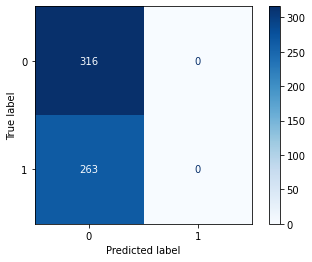

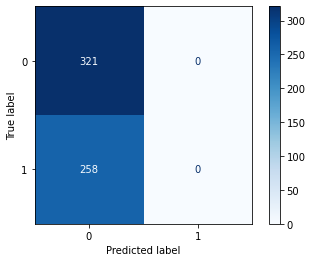

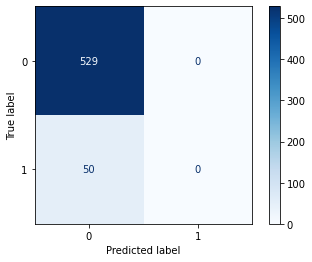

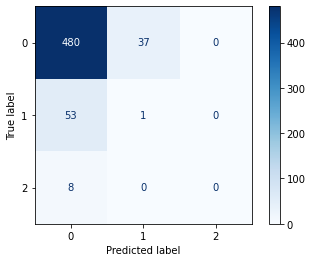

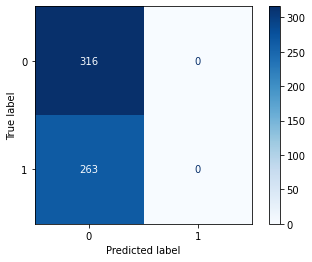

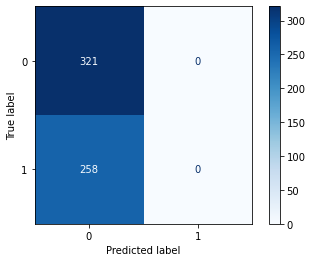

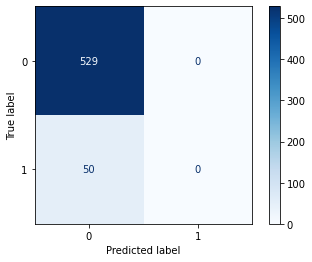

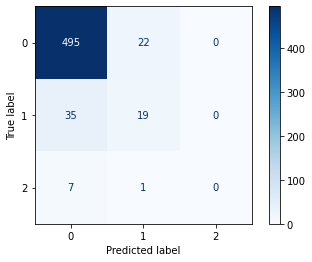

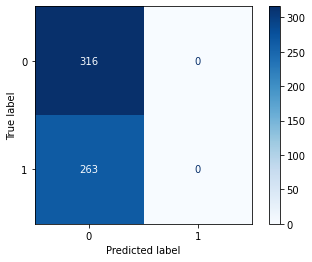

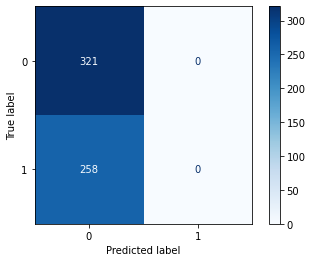

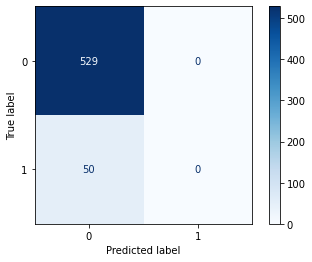

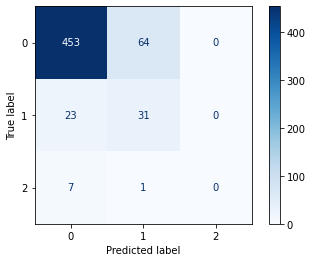

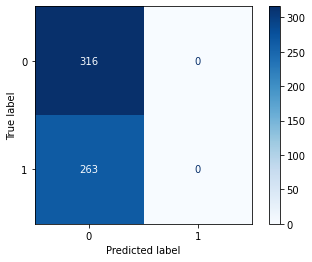

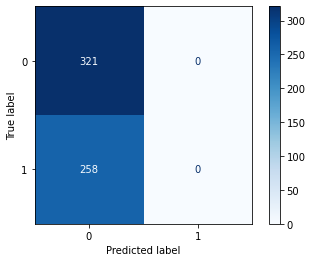

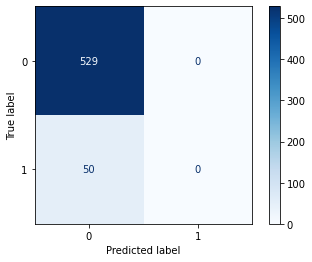

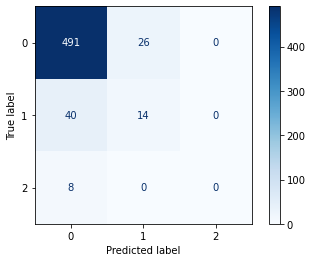

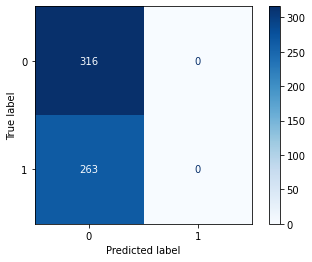

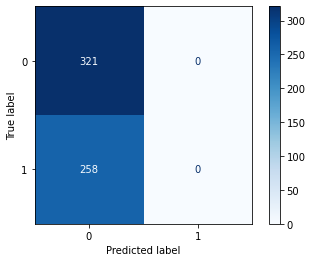

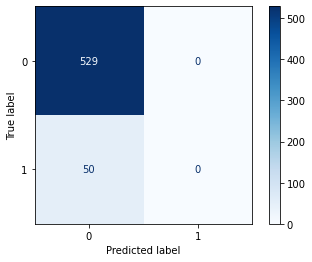

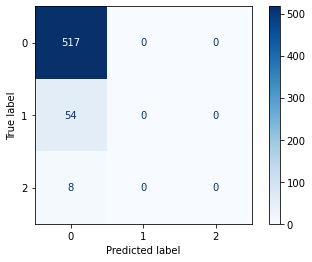

In [23]:
wandb.agent(sweep_id, function=wandb_sweep, count=10)

In [24]:
import gc
#def report_gpu():
#print(torch.cuda.list_gpu_processes())
#gc.collect()
#torch.cuda.empty_cache()

In [25]:
# measure how long training is going to take
#print("[INFO] training the network...")
#startTime = time.time()

In [26]:
wandb.finish()

In [27]:
wandb.finish()

api = wandb.Api()
sweep = api.sweep("xmatovice/uncategorized/sweeps/" + sweep_id)

best_run = sweep.best_run()
print(best_run.id)
pprint(best_run.config)

wandb: Sorting runs by +summary_metrics.val_loss


8480i9mb
{'batch_size': 8,
 'epochs': 10,
 'learning_rate': 0.05657808132757078,
 'momentum': 0.7500727372948774,
 'n_features': 256}
